In [50]:
import pickle, os, torch
import os.path as osp
import numpy as np
import matplotlib.pyplot as plt

In [51]:
folder = 'results_sweep_smass_040122'
run = 'Sage_vlarge_all_4t_z0.0_quantile_raw_vculwx'
pointer=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphResults/{folder}/{run}')    

In [142]:
lows=[]
pred = []
  
results=pickle.load(open(osp.join(pointer,'result_dict.pkl'), 'rb'))
ys=results['ys']+9
pred=results['pred']+9
config=pickle.load(open(osp.join(pointer,'construct_dict.pkl'), 'rb'))
data_p=config["data_params"]
print(config)

{'experiment': 'GraphMerge', 'group': 'sweep_smass', 'move': False, 'model': 'Sage', 'log': True, 'run_params': {'n_epochs': 250, 'n_trials': 1, 'batch_size': 512, 'val_epoch': 2, 'early_stopping': True, 'patience': 20, 'l1_lambda': 0.0, 'l2_lambda': 0.0, 'loss_func': 'L2', 'metrics': 'test_multi', 'performance_plot': 'SAM_base', 'shuffle': True, 'save': True, 'seed': False, 'num_workers': 4}, 'learn_params': {'learning_rate': 0.001, 'schedule': 'warmup_expcos', 'g_up': 1, 'g_down': 0.95, 'warmup': 4, 'period': 10, 'eta_min': 1e-05}, 'hyper_params': {'hidden_channels': 128, 'conv_layers': 5, 'conv_activation': 'relu', 'decode_activation': 'leakyrelu', 'decode_layers': 2, 'layernorm': True, 'agg': 'sum', 'variance': False, 'rho': 0, 'in_channels': 43, 'out_channels': 1}, 'data_params': {'case': 'vlarge_all_4t_z0.0_quantile_raw', 'targets': [0], 'split': 0.8, 'shuffle': 0}, 'experiment_name': 'lea0.001g_u1.7g_d0.95con5.0dec2.0hid128.0l1_0.0l2_0.0'}


In [53]:
datat=pickle.load(open(osp.expanduser(f'~/../../../scratch/gpfs/cj1223/GraphStorage/{data_p["case"]}/data.pkl'), 'rb'))
from torch_geometric.data import Data
data=[]
for d in datat:
    data.append(Data(x=d.x, edge_index=d.edge_index, edge_attr=d.edge_attr, y=d.y[[data_p["targets"]]]))

In [143]:
if not data_p["shuffle"]:
    test_data=data[int(len(data)*0.8):]
    train_data=data[:int(len(data)*0.8)]    

In [163]:
Mhf=[]
M200= []
M500 = []
M2500 = []
for d in test_data:
    Mhf.append(d.x.numpy()[0,3])
    M200.append(d.x.numpy()[0,23])
    M500.append(d.x.numpy()[0,24])
    M2500.append(d.x.numpy()[0,25])  
    

In [164]:
transform_path=osp.expanduser(f'~/../../scratch/gpfs/cj1223/GraphStorage')  
transformer=pickle.load(open(osp.join(transform_path,'transformers','quantile_allfeat_1.pkl'), 'rb'))

In [165]:
Mhf=np.hstack(transformer[10].inverse_transform(np.array(Mhf).reshape(-1,1)))
M200=np.hstack(transformer[40].inverse_transform(np.array(M200).reshape(-1,1)))
M500=np.hstack(transformer[40].inverse_transform(np.array(M500).reshape(-1,1)))
M2500=np.hstack(transformer[40].inverse_transform(np.array(M2500).reshape(-1,1)))

In [191]:
nbins=25
edges=np.percentile(Mhf, np.linspace(0,100,nbins))
# edges=np.linspace(min(Mhf), max(Mhf),nbins)
centers=(edges[:-1]+edges[1:])/2
sigM=[]
ysigs, predsigs = [], []
for i in range(len(edges)-1):
    mask=np.logical_and(edges[i]<=Mhf,edges[i+1]>=Mhf)
    ysigs.append(np.std(ys[mask]))
    predsigs.append(np.std(pred[mask]))
    sigM.append(np.std(pred[mask]-ys[mask]))
sigM=np.array(sigM)
ysigs, predsigs = np.array(ysigs), np.array(predsigs)

In [212]:
nbins=25
edges1=np.percentile(ys, np.linspace(0,100,nbins))
centers_Ms=(edges1[:-1]+edges1[1:])/2
sigMs=[]
ysig_Ms, predsig_Ms = [], []
for i in range(len(edges1)-1):
    mask=np.logical_and(edges1[i]<=ys,edges1[i+1]>=ys)
    ysig_Ms.append(np.std(ys[mask]))
    predsig_Ms.append(np.std(pred[mask]))
    sigMs.append(np.std(pred[mask]-ys[mask]))
sigMs=np.array(sigMs)
ysig_Ms, predsig_Ms = np.array(ysig_Ms), np.array(predsig_Ms)

In [213]:
edges1

array([ 3.53710604,  6.70380272,  6.84940247,  6.93820852,  7.0031991 ,
        7.06565551,  7.12801552,  7.19135694,  7.25635624,  7.32047385,
        7.39353267,  7.46770714,  7.55119991,  7.63494804,  7.72626662,
        7.82915771,  7.93983539,  8.06369189,  8.20896077,  8.38236733,
        8.58090687,  8.86869991,  9.27022258,  9.92421174, 11.47061157])

In [214]:
np.std(ys[np.logical_and(ys>6.7, ys<10)])

0.7343173

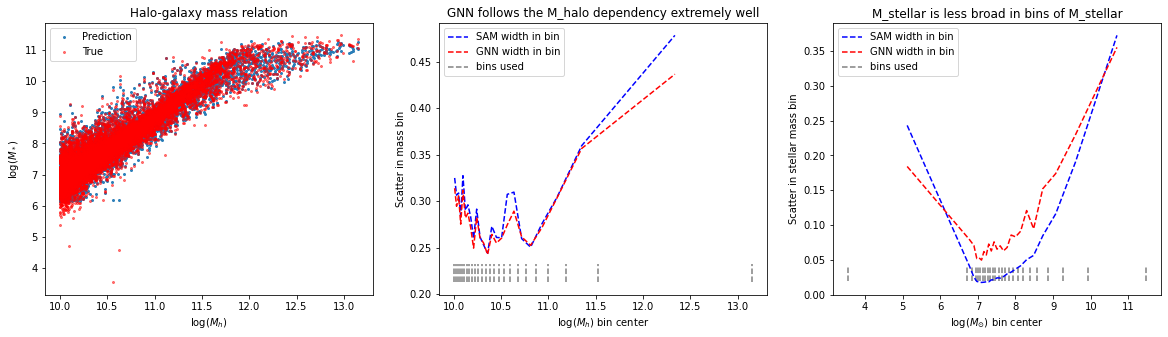

In [217]:
fig, ax =plt.subplots(ncols=3,nrows=1, figsize=(20,5))
ax=ax.flatten()
ax[0].plot(Mhf, pred,'o', markersize=2, alpha=0.9, label='Prediction')
ax[0].plot(Mhf, ys,'ro', markersize=2, alpha=0.5, label='True')
ax[0].set(xlabel=r'log($M_h$)', ylabel=r'log($M_*$)', title='Halo-galaxy mass relation')
ax[0].legend()
ax[1].vlines(edges, min(predsigs)-0.03, min(predsigs)-0.01, color='gray', linestyle='--', label='bins used')
ax[1].plot(centers, ysigs, 'b--', label='SAM width in bin')
ax[1].plot(centers, predsigs, 'r--', label='GNN width in bin')
ax[1].set(xlabel=r'log($M_h$) bin center', ylabel=r'Scatter in mass bin', title='GNN follows the M_halo dependency extremely well')
ax[1].legend()

ax[2].vlines(edges1, min(predsig_Ms)-0.03, min(predsig_Ms)-0.01, color='gray', linestyle='--', label='bins used')
ax[2].plot(centers_Ms, ysig_Ms, 'b--', label='SAM width in bin')
ax[2].plot(centers_Ms, predsig_Ms, 'r--', label='GNN width in bin')
ax[2].set(xlabel=r'log($M_{\odot}$) bin center', ylabel=r'Scatter in stellar mass bin', title='M_stellar is less broad in bins of M_stellar')
ax[2].legend()

In [200]:
ysigs-predsigs

array([ 0.01105541,  0.01191995,  0.00304809,  0.00928512,  0.01566625,
        0.00813437,  0.00902057,  0.01153067,  0.01034512,  0.0086295 ,
        0.0009703 , -0.0019989 ,  0.00131677,  0.00872439,  0.0060257 ,
        0.00031623,  0.03277737,  0.02048448, -0.00189579, -0.00198975,
        0.00412482,  0.00062755,  0.00296748,  0.04178143], dtype=float32)

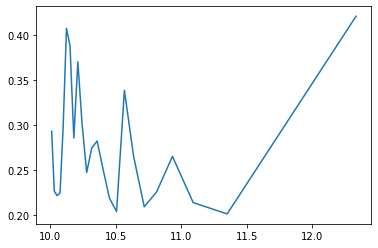

In [174]:
plt.plot( centers, np.array(sigM)/np.array(ysigs))

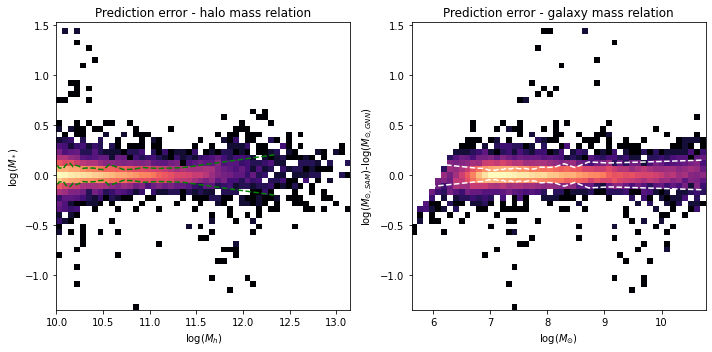

In [185]:
import matplotlib as mpl
bins=50
l=0.02
res=ys.flatten()-pred.flatten()
fig, ax =plt.subplots(ncols=2,nrows=1, figsize=(10,5))
ax=ax.flatten()
ax[0].hist2d(np.array(Mhf), res, bins=bins, range=[np.percentile(Mhf, [0,100]),
            np.percentile(res, [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)
ax[0].plot(centers, sigM, 'g--')
ax[0].plot(centers, -sigM, 'g--')

ax[0].set(xlabel=r'log($M_h$)', ylabel=r'log($M_*$)', title='Prediction error - halo mass relation')
# ax[0].legend()
ax[1].hist2d(ys.flatten(), res, bins=bins, range=[np.percentile(ys.flatten(), [l,100-1]),
            np.percentile(res, [0+l,100-l])], norm=mpl.colors.LogNorm(), cmap=mpl.cm.magma)

ax[1].plot(centers_Ms, sigMs, 'w--')
ax[1].plot(centers_Ms, -sigMs, 'w--')

ax[1].set(xlabel=r'log($M_{\odot}$)', 
          ylabel=r'log($M_{\odot, SAM}$)-log($M_{\odot,GNN}$)', 
          title='Prediction error - galaxy mass relation')
# ax[1].legend()
fig.tight_layout()

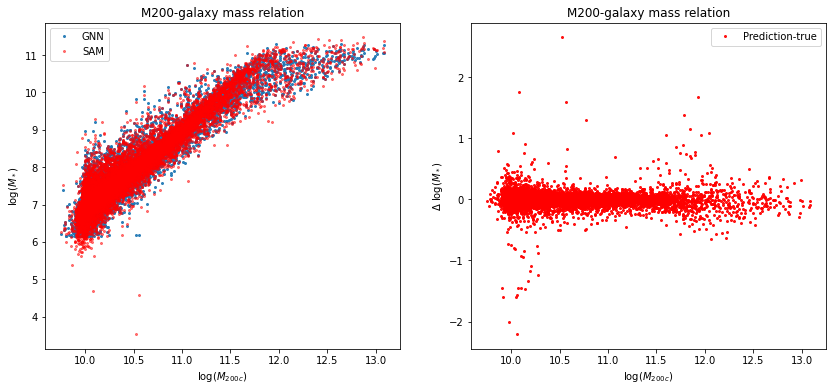

In [220]:
fig, ax =plt.subplots(ncols=2,nrows=1, figsize=(14,6))
ax=ax.flatten()
ax[0].plot(M200, pred,'o', markersize=2, alpha=0.9, label='GNN')
ax[0].plot(M200, ys,'ro', markersize=2, alpha=0.5, label='SAM')
ax[0].set(xlabel=r'log($M_{200c}$)', ylabel=r'log($M_*$)', title='M200-galaxy mass relation')
ax[0].legend()
ax[1].plot(M200, pred-ys,'ro', markersize=2, alpha=0.9, label='Prediction-true')
ax[1].set(xlabel=r'log($M_{200c}$)', ylabel=r'$\Delta$ log($M_*$)', title='M200-galaxy mass relation')
ax[1].legend()